In [2]:
!pip install torch-summary

In [3]:
try:
    import fastmri
    print("fastmri is already installed.")
except ImportError:

    print("fastmri is not installed. Installing...")
    !pip install fastmri

fastmri is already installed.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Configuration

In [5]:
# Constants
TRAIN = False
DEBUG = True

drive_path = '/content/drive/MyDrive/DL project'   # Fidel Path
# drive_path = '/content/drive/MyDrive'             # Kyaw Path
# drive_path = '/content/drive/MyDrive'             # Daniel Path

drive_ds_path = f'{drive_path}/fastmri_data'
checkpoint_folder = f'{drive_ds_path}/checkpoints/12082024'
injury_model_path = f'{drive_ds_path}/kneeMRI/injury_detection_model.pth'

In [6]:
import os
import cv2
import h5py
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import PIL
from matplotlib import colormaps
from matplotlib import cm

from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import models
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image

import fastmri
from fastmri.data import transforms as T
from fastmri.data import subsample, mri_data

import time

import pickle
from torchvision.transforms.functional import normalize
from skimage.metrics import structural_similarity as ssim

In [7]:
def print_time_delta(title, start_time):
  if DEBUG:
    end_time = time.time()
    total_time = end_time - start_time
    hour, rem = divmod(total_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f'{title} Time: {int(hour)}h {int(minutes)}m {int(seconds)}s')

def print_step(title, step=None):
  if DEBUG:
    if step is None:
      print(f'{title}')
    else:
      print(f'{title} Step: {step}')

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [9]:
class MRNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = models.alexnet(pretrained=True)
        self._replace_relu_inplace(self.model.features)
        self._replace_relu_inplace(self.model.classifier)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 1)

    def _replace_relu_inplace(self, layer):
        for idx, module in enumerate(layer):
            if isinstance(module, nn.ReLU) and module.inplace:
                layer[idx] = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.model.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            self.conv_block(1, 64),
            nn.MaxPool2d(2)
        )
        self.middle = self.conv_block(64, 128)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            self.conv_block(64, 64),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=False)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

In [11]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, target_class=None):
        self.model.zero_grad()

        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1)
        elif isinstance(target_class, int):
            target_class = torch.full((input_tensor.size(0),), target_class, dtype=torch.long, device=input_tensor.device)

        one_hot = torch.zeros_like(output)
        one_hot.scatter_(1, target_class.view(-1, 1), 1)
        output.backward(gradient=one_hot)

        gradients = self.gradients  # [N, C, H, W]
        activations = self.activations  # [N, C, H, W]

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # [N, C, 1, 1]

        cam = torch.sum(weights * activations, dim=1)  # [N, H, W]
        cam = F.relu(cam)

        cam_min = cam.view(cam.size(0), -1).min(dim=1)[0].view(-1, 1, 1)
        cam_max = cam.view(cam.size(0), -1).max(dim=1)[0].view(-1, 1, 1)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)

        return cam

In [12]:
def data_transform(
    kspace,
    mask_func,
    grad_cam,
    target,
    data_attributes,
    filename,
    slice_num,
    plot_heatmap=True,
    ):
    print_step('\nData Transformation', 'Starting')
    start_time = time.time()

    target_size = (320, 186)
    fixed_slices = 40

    print_step('Data Transformation', 'Convert k-space to tensor')
    kspace_tensor = T.to_tensor(kspace)
    masked_kspace, mask, _ = T.apply_mask(kspace_tensor, mask_func)
    image = fastmri.ifft2c(masked_kspace)
    image_abs = fastmri.complex_abs(image)

    print_step('Data Transformation', 'Resize image_abs')
    image_abs = TF.resize(image_abs, target_size)

    print_step('Data Transformation', 'Process the target if available')
    if target is not None:
        target = T.to_tensor(target)
        target = TF.resize(target, target_size)

    print_step('Data Transformation', 'Normalize each slice')
    min_vals = image_abs.view(image_abs.size(0), -1).min(dim=1)[0].view(-1, 1, 1)
    input_tensors = image_abs / (min_vals + 1e-8)

    print_step('Data Transformation', 'Prepare input tensors for the model')
    input_tensors = input_tensors.unsqueeze(1)
    input_tensors = input_tensors.repeat(1, 3, 1, 1).cuda()

    print_step('Data Transformation', 'Generate Grad-CAM heatmaps in batch')
    with torch.enable_grad():
      heatmaps = grad_cam.generate_cam(input_tensors, target_class=0)

    print_step('Data Transformation', 'Resize heatmaps to target size')
    heatmaps = TF.resize(heatmaps.unsqueeze(1).cpu(), target_size)
    weight_map = heatmaps.squeeze(1)

    print_time_delta('Data Transformation', start_time)
    return image_abs, target, weight_map

In [13]:
class MRIDataset(Dataset):
    def __init__(self, root, grad_cam, mask_func, transform=None, challenge="singlecoil"):
        self.root = pathlib.Path(root)
        self.file_paths = sorted(self.root.glob("*.h5"))
        self.transform = transform
        self.challenge = challenge

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # print_step('\nMRIDataset', 'Starting')
        start_time = time.time()

        file_path = self.file_paths[idx]

        # print_step('MRIDataset', f'Loading file {file_path.name}')
        with h5py.File(file_path, 'r') as f:
            kspace = f["kspace"][:]

            target = f.get("reconstruction_esc")

            if target is None:
                print(f"Warning: No valid target found in {file_path.name}, skipping...")
                return self.__getitem__((idx + 1) % len(self))

            target = target[:]
            data_attributes = dict(f.attrs)

        # print_step('MRIDataset', 'Start Transformation')
        if self.transform:
            image, target, weight_map = self.transform(
                kspace, mask_func=mask_func, grad_cam=grad_cam, target=target, data_attributes=data_attributes,
                filename=file_path.name, slice_num=idx
            )

        # print_time_delta('MRIDataset end', start_time)

        return image, target, weight_map

In [14]:
def weighted_mse_loss(prediction, target, weight_map, epsilon=1e-6):

    weight_map = torch.clamp(weight_map, min=epsilon)
    mse = (prediction - target) ** 2
    weighted_loss = torch.mean(weight_map * mse)

    return weighted_loss

def show_or_save(save_path):
    if save_path:
        plt.savefig(save_path)
        print(f"Learning curve saved to {save_path}")
    else:
        plt.show()


def plot_loss(train_losses, val_losses, save_path=None):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()

    plt.xticks(range(1, len(train_losses) + 1))

    plt.ticklabel_format(axis='y', style='plain', useOffset=False)
    show_or_save(save_path)
    plt.close()

def plot_learning_curve(learning_rates, save_path=None):
    epochs = range(1, len(learning_rates) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, learning_rates, label='Learning Rate', color='tab:orange', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)

    show_or_save(save_path)
    plt.close()

def plot_loss_and_learning_curve(train_losses, val_losses, learning_rates, save_path=None):
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Loss
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(epochs, train_losses, label='Train Loss', color='tab:blue', marker='o')
    ax1.plot(epochs, val_losses, label='Validation Loss', color='tab:cyan', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')

    # Learning rate
    ax2 = ax1.twinx()
    ax2.set_ylabel('Learning Rate', color='tab:orange')
    ax2.plot(epochs, learning_rates, label='Learning Rate', color='tab:orange', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.legend(loc='upper right')

    plt.title('Loss and Learning Rate Curves')
    fig.tight_layout()
    show_or_save(save_path)
    plt.close()

def save_checkpoint(
    epoch,
    model,
    optimizer,
    loss,
    checkpoint_dir,
    filename
  ):

    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

def load_checkpoint(checkpoint_path, model, optimizer=None):

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}.")
    return start_epoch, checkpoint.get("loss", None)

# Training

In [15]:
def train(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    epochs,
    checkpoint_interval=1,
    checkpoint_dir=checkpoint_folder,
    resume_from_checkpoint=False
):
    start_time = time.time()
    print_step('Training', 'Starting')

    learning_rates = []
    train_losses = []
    val_losses = []
    start_epoch = 1

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    if resume_from_checkpoint:
        checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
        print_step('Training', f'Checkpoint path: {checkpoint_path}')
        if os.path.exists(checkpoint_path):
            start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer)
            print_step('Training', f'Resuming from epoch {start_epoch}.')
        else:
            print_step("No checkpoint found. Starting from scratch.")

    end_epoch = start_epoch + epochs - 1

    scaler = torch.cuda.amp.GradScaler()
    accumulation_steps = 2

    for epoch in range(start_epoch, end_epoch + 1):
        print(
            '\n*** *** *** *** *** Training',
            f'Step: Starting Epoch {epoch}/{end_epoch}',
            '*** *** *** *** ***'
        )

        epoch_start_time = time.time()

        # Log learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        # print_step('Training', f'Current Learning Rate: {current_lr}')


        model.train()
        running_train_loss = 0.0

        print_step('Training', f'Loading Data for Epoch {epoch}/{end_epoch}')
        for batch_idx, (image, target, weight_map) in enumerate(train_dataloader):

            batch_start_time = time.time()
            print_step('Training', f'Processing Batch {batch_idx + 1}/{len(train_dataloader)}')

            batch_size, slices, height, width = image.shape

            image = image.view(batch_size * slices, 1, height, width)
            target = target.view(batch_size * slices, 1, height, width)
            weight_map = weight_map.view(batch_size * slices, 1, height, width)

            image, target, weight_map = image.cuda(), target.cuda(), weight_map.cuda()

            with torch.cuda.amp.autocast():
                output = model(image)
                loss = weighted_mse_loss(output, target, weight_map)

            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_dataloader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_train_loss += loss.item()

            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_dataloader):
                print_step(
                    'Training',
                    f'Epoch {epoch}/{end_epoch}, Batch {batch_idx + 1}/{len(train_dataloader)}, Loss: {loss.item():.10f}'
                )

            print_time_delta('Batch', batch_start_time)
            print_time_delta('Total Training (Cumulative)', start_time)

        avg_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print_step('Training', f'Epoch {epoch}/{end_epoch} completed. Average Training Loss: {avg_train_loss:.6f}')

        # Evaluation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for image, target, weight_map in val_dataloader:

                batch_size, slices, height, width = image.shape

                image = image.view(batch_size * slices, 1, height, width)
                target = target.view(batch_size * slices, 1, height, width)
                weight_map = weight_map.view(batch_size * slices, 1, height, width)

                image, target, weight_map = image.cuda(), target.cuda(), weight_map.cuda()

                with torch.cuda.amp.autocast():
                    output = model(image)
                    loss = weighted_mse_loss(output, target, weight_map)

                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        print_step('Validation', f'Epoch {epoch}/{end_epoch} completed. Average Validation Loss: {avg_val_loss:.6f}')

        print_time_delta('Epoch', epoch_start_time)

        if epoch % checkpoint_interval == 0:
            checkpoint_start_time = time.time()
            save_checkpoint(epoch, model, optimizer, avg_train_loss, checkpoint_dir, filename='checkpoint.pth')
            print_step('Training', f'Checkpoint saved at {checkpoint_path}')
            print_time_delta('Checkpoint Save', checkpoint_start_time)

    print_step('Training', 'Saving the final model...')
    save_model_start_time = time.time()

    final_model_path = os.path.join(checkpoint_dir, "final_model.pth")
    torch.save(model.state_dict(), final_model_path)
    print_step('Training', f'Final model saved at {final_model_path}')
    print_time_delta('Final Model Save', save_model_start_time)

    print_step('Training', 'Generating plots...')
    plot_loss(train_losses, val_losses)

    print_step('Training', 'Saving metrics...')
    metrics = (train_losses, val_losses, learning_rates)
    np.save(os.path.join(checkpoint_dir, "metrics.npy"), metrics)

    print_step('Training', 'COMPLETE.')
    print_time_delta('Total Training', start_time)

    return train_losses, val_losses, learning_rates

In [16]:
injury_model = MRNet().cuda()

# The injury detection model is not provided as the size does not allow for upload
# See the 'Injury_Detection_Model.ipynb' notebook to create the injury model.
injury_model_path = f"{drive_path}/fastmri_data/kneeMRI/injury_detection_model.pth"
injury_model.load_state_dict(torch.load(injury_model_path))
injury_model.eval()

target_layer = injury_model.model.features[10]
grad_cam = GradCAM(injury_model, target_layer)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-16-10ce08105056>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details)

In [17]:
# mask_func = subsample.RandomMaskFunc(
#     center_fractions=[0.08, 0.04],
#     accelerations=[4, 8]
# )

mask_func = subsample.RandomMaskFunc(
    center_fractions=[0.1, 0.15],
    accelerations=[2, 4]
)

train_dataset = MRIDataset(
    # root=f'{drive_ds_path}/knee_dataset/singlecoil_train',
    root=f'{drive_ds_path}/single coil_train_sub',
    transform=data_transform,
    challenge='singlecoil',
    grad_cam=grad_cam,
    mask_func=mask_func
)

val_dataset = MRIDataset(
    # root=f'{drive_ds_path}/knee_dataset/singlecoil_val',
    root=f'{drive_ds_path}/single coil_val_sub',
    transform=data_transform,
    challenge='singlecoil',
    grad_cam=grad_cam,
    mask_func=mask_func
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True
)

In [18]:
from sklearn.metrics import accuracy_score
from torch.utils.data import Subset

# Reset metrics
learning_rates = None
train_losses = None,
val_losses = None

if __name__ == "__main__" and TRAIN:
    MRI_reconstruction_model = UNet().cuda()
    optimizer = optim.Adam(MRI_reconstruction_model.parameters(), lr=1e-3)
    train_losses, val_losses, learning_rates = train(
        MRI_reconstruction_model,
        train_dataloader,
        val_dataloader,
        optimizer,
        epochs=10,
        resume_from_checkpoint=True,
    )

if learning_rates is None:
    train_losses, val_losses, learning_rates = np.load(os.path.join(checkpoint_folder, "metrics.npy"), allow_pickle=True)

train_losses, val_losses, learning_rates

(array([1.50765670e-03, 7.19886144e-05, 2.52729178e-05, 1.42548225e-05,
        8.38065343e-06, 5.88753960e-06, 4.91982578e-06, 4.47175037e-06,
        4.13724390e-06, 3.81420948e-06]),
 array([6.96908925e-06, 1.53695219e-05, 1.39483091e-05, 5.80879835e-06,
        4.80166045e-06, 5.07838922e-06, 5.11073783e-06, 4.74542564e-06,
        3.58508661e-06, 3.54144534e-06]),
 array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
        0.001]))

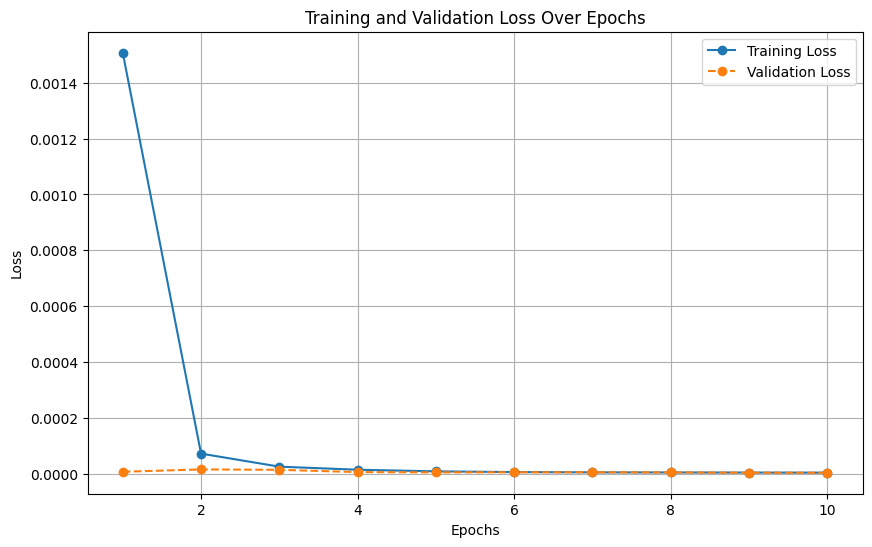

In [19]:
epochs = range(1, len(train_losses) + 1 )

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()
plt.close()

# Testing

In [20]:
def test_data_transform(
    kspace,
    mask_func,
    grad_cam,
    target,
    data_attributes,
    filename,
    slice_num,
    plot_heatmap=True,
    ):
    print_step('\nData Transformation', 'Starting')
    start_time = time.time()

    target_size = (320, 186)
    fixed_slices = 40

    print_step('Data Transformation', 'Convert k-space to tensor')
    kspace_tensor = T.to_tensor(kspace)
    masked_kspace, mask, _ = T.apply_mask(kspace_tensor, mask_func)
    image = fastmri.ifft2c(masked_kspace)
    image_abs = fastmri.complex_abs(image)

    image_abs2 = image_abs.detach().clone()
    image_abs2 = image_abs2 / torch.max(image_abs2)
    image_abs2 = TF.resize(image_abs2, target_size)

    print_step('Data Transformation', 'Resize image_abs')
    image_abs = TF.resize(image_abs, target_size)

    print_step('Data Transformation', 'Process the target if available')
    if target is not None:
        target = T.to_tensor(target)
        target = TF.resize(target, target_size)

    print_step('Data Transformation', 'Normalize each slice')
    min_vals = image_abs.view(image_abs.size(0), -1).min(dim=1)[0].view(-1, 1, 1)
    input_tensors = image_abs / (min_vals + 1e-8)

    print_step('Data Transformation', 'Prepare input tensors for the model')
    input_tensors = input_tensors.unsqueeze(1)
    input_tensors = input_tensors.repeat(1, 3, 1, 1).cuda()

    print_step('Data Transformation', 'Generate Grad-CAM heatmaps in batch')
    with torch.enable_grad():
      heatmaps = grad_cam.generate_cam(input_tensors, target_class=0)

    print_step('Data Transformation', 'Resize heatmaps to target size')
    heatmaps = TF.resize(heatmaps.unsqueeze(1).cpu(), target_size)
    weight_map = heatmaps.squeeze(1)

    print_time_delta('Data Transformation', start_time)
    return image_abs, image_abs2, target, weight_map

In [21]:
class MRIDataset2(Dataset):
    def __init__(self, root, grad_cam, mask_func, transform=None, challenge="singlecoil"):
        self.root = pathlib.Path(root)
        self.file_paths = sorted(self.root.glob("*.h5"))
        self.transform = transform
        self.challenge = challenge

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # print_step('\nMRIDataset', 'Starting')
        start_time = time.time()

        file_path = self.file_paths[idx]

        # print_step('MRIDataset', f'Loading file {file_path.name}')
        with h5py.File(file_path, 'r') as f:
            kspace = f["kspace"][:]

            target = f.get("reconstruction_esc")

            if target is None:
                print(f"Warning: No valid target found in {file_path.name}, skipping...")
                return self.__getitem__((idx + 1) % len(self))

            target = target[:]
            data_attributes = dict(f.attrs)

        # print_step('MRIDataset', 'Start Transformation')
        if self.transform:
            image, image2, target, weight_map = self.transform(
                kspace, mask_func=mask_func, grad_cam=grad_cam, target=target, data_attributes=data_attributes,
                filename=file_path.name, slice_num=idx
            )

        # print_time_delta('MRIDataset end', start_time)

        return image, image2, target, weight_map

In [22]:
def display_images(images, titles, output, heatmap):
    num_images = len(images) + 2
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))

    if num_images == 1:
        axes = [axes]

    for idx, ax in enumerate(axes):
      if idx < len(images):
        image = images[idx]
        title = titles[idx]
        display_image(image, title=title, ax=ax)
      else:
        break

    display_heatmap_overlay(output, heatmap, title='Grad-CAM Heatmap Overlay', ax=axes[-1])
    display_heatmap_overlay(None, heatmap, title='Grad-CAM Heatmap', ax=axes[-2])

    plt.tight_layout()
    plt.show()

def display_image(image, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

def display_heatmap_overlay(image, heatmap, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    if image is not None:
      ax.imshow(image, cmap='gray')

    img = ax.imshow(heatmap, cmap='jet', alpha=0.3 if image is not None else 1)
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(img, ax=ax)

def visualize_error_map(output_img, ground_truth):
    error_map = abs(output_img - ground_truth)
    plt.figure(figsize=(5, 5))
    plt.imshow(error_map, cmap="plasma")
    plt.title(f"Error Map")
    plt.axis("off")
    plt.colorbar()
    plt.show()

def test(model, dataloader, grad_cam, mask_func, max_slices=5):

    model.eval()
    running_test_loss = 0.0
    num_images = 0

    print_step('\nTesting', 'Starting')
    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (image, image2, target, weight_map) in enumerate(dataloader):

            image = image.squeeze(0)
            image2 = image2.squeeze(0)
            image2 = image2.numpy()
            target = target.squeeze(0)
            weight_map = weight_map.squeeze(0)

            num_slices, height, width = image.shape

            for slice_idx in range(num_slices):

                middle_idx = num_slices // 2

                slice_image2 = image2[slice_idx]
                slice_image2 = slice_image2/np.min(slice_image2)
                slice_image2 = torch.from_numpy(slice_image2).unsqueeze(0).unsqueeze(0)
                slice_image2 = slice_image2.float()

                slice_image = image[slice_idx].unsqueeze(0).unsqueeze(0)
                slice_target = target[slice_idx].unsqueeze(0).unsqueeze(0)
                slice_weight_map = weight_map[slice_idx].unsqueeze(0).unsqueeze(0)

                slice_image, slice_image2, slice_target, slice_weight_map = (
                    slice_image.cuda(),
                    slice_image2.cuda(),
                    slice_target.cuda(),
                    slice_weight_map.cuda(),
                )

                device = torch.device('cuda')
                model = model.to(device)
                slice_image = slice_image.to(device)
                slice_image2 = slice_image2.to(device)
                slice_target = slice_target.to(device)
                slice_weight_map = slice_weight_map.to(device)

                model.zero_grad()
                with torch.enable_grad():
                    output = model(slice_image2)
                    loss = weighted_mse_loss(output, slice_target, slice_weight_map)

                output_image = output.squeeze().cpu().detach().numpy()
                output_image = output_image - np.min(output_image)/ np.max(output_image)

                running_test_loss += loss.item()
                num_images += 1

                if slice_idx == middle_idx and batch_idx < 5:
                    input_img = slice_image.squeeze().cpu().numpy()
                    ground_truth = slice_target.squeeze().cpu().numpy()
                    heatmap = slice_weight_map.squeeze().cpu().numpy()

                    images = [input_img, ground_truth, output_image]
                    titles = ['Input Image', 'Target Image', 'Output Image']

                    display_images(images, titles, output_image, heatmap)
                    visualize_error_map(ground_truth, output_image)

    avg_test_loss = running_test_loss / num_images
    print_step('\nTesting', f'Average Test Loss: {avg_test_loss:.10f}')
    print_time_delta('Testing', start_time)
    return avg_test_loss

In [23]:
mask_func = subsample.RandomMaskFunc(
    center_fractions=[0.08, 0.04],
    accelerations=[4, 8]
)

MRI_reconstruction_model = UNet().cuda()

state_dict = torch.load(f'{drive_path}/fastmri_data/checkpoints/12082024/final_model.pth')
MRI_reconstruction_model.load_state_dict(state_dict)

test_dataset = MRIDataset2(
    root=f'{drive_path}/fastmri_data/knee_dataset/singlecoil_val',
    grad_cam=grad_cam,
    mask_func=mask_func,
    transform=test_data_transform,
    challenge="singlecoil",
)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)



<ipython-input-23-a56c051ecd82>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{drive_path}/fastmri_data/checkpoints/12082024/final_model.pth')


In [35]:
test(
  model=MRI_reconstruction_model,
  dataloader=test_dataloader,
  grad_cam=grad_cam,
  mask_func=mask_func,
  max_slices=1,
)

Output hidden; open in https://colab.research.google.com to view.

# Reviewing the Final Model

In [25]:
from torchsummary import summary

In [26]:
summary(MRI_reconstruction_model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  640
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  36,928
|    |    └─ReLU: 3-4                    --
|    └─MaxPool2d: 2-2                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-3                       73,856
|    └─ReLU: 2-4                         --
|    └─Conv2d: 2-5                       147,584
|    └─ReLU: 2-6                         --
├─Sequential: 1-3                        --
|    └─ConvTranspose2d: 2-7              32,832
|    └─Sequential: 2-8                   --
|    |    └─Conv2d: 3-5                  36,928
|    |    └─ReLU: 3-6                    --
|    |    └─Conv2d: 3-7                  36,928
|    |    └─ReLU: 3-8                    --
|    └─Conv2d: 2-9                       65
Total params: 365,761
Trainable params: 365,7

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  640
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  36,928
|    |    └─ReLU: 3-4                    --
|    └─MaxPool2d: 2-2                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-3                       73,856
|    └─ReLU: 2-4                         --
|    └─Conv2d: 2-5                       147,584
|    └─ReLU: 2-6                         --
├─Sequential: 1-3                        --
|    └─ConvTranspose2d: 2-7              32,832
|    └─Sequential: 2-8                   --
|    |    └─Conv2d: 3-5                  36,928
|    |    └─ReLU: 3-6                    --
|    |    └─Conv2d: 3-7                  36,928
|    |    └─ReLU: 3-8                    --
|    └─Conv2d: 2-9                       65
Total params: 365,761
Trainable params: 365,7

In [27]:
summary(injury_model)

Layer (type:depth-idx)                   Param #
├─AlexNet: 1-1                           --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  23,296
|    |    └─ReLU: 3-2                    --
|    |    └─MaxPool2d: 3-3               --
|    |    └─Conv2d: 3-4                  307,392
|    |    └─ReLU: 3-5                    --
|    |    └─MaxPool2d: 3-6               --
|    |    └─Conv2d: 3-7                  663,936
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  884,992
|    |    └─ReLU: 3-10                   --
|    |    └─Conv2d: 3-11                 590,080
|    |    └─ReLU: 3-12                   --
|    |    └─MaxPool2d: 3-13              --
|    └─AdaptiveAvgPool2d: 2-2            --
|    └─Sequential: 2-3                   --
|    |    └─Dropout: 3-14                --
|    |    └─Linear: 3-15                 37,752,832
|    |    └─ReLU: 3-16                   --
|    |    └─Dropout: 3-17              

Layer (type:depth-idx)                   Param #
├─AlexNet: 1-1                           --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  23,296
|    |    └─ReLU: 3-2                    --
|    |    └─MaxPool2d: 3-3               --
|    |    └─Conv2d: 3-4                  307,392
|    |    └─ReLU: 3-5                    --
|    |    └─MaxPool2d: 3-6               --
|    |    └─Conv2d: 3-7                  663,936
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  884,992
|    |    └─ReLU: 3-10                   --
|    |    └─Conv2d: 3-11                 590,080
|    |    └─ReLU: 3-12                   --
|    |    └─MaxPool2d: 3-13              --
|    └─AdaptiveAvgPool2d: 2-2            --
|    └─Sequential: 2-3                   --
|    |    └─Dropout: 3-14                --
|    |    └─Linear: 3-15                 37,752,832
|    |    └─ReLU: 3-16                   --
|    |    └─Dropout: 3-17              

In [28]:
for name, param in MRI_reconstruction_model.named_parameters():
    print(f"{name}: {param.shape}")

encoder.0.0.weight: torch.Size([64, 1, 3, 3])
encoder.0.0.bias: torch.Size([64])
encoder.0.2.weight: torch.Size([64, 64, 3, 3])
encoder.0.2.bias: torch.Size([64])
middle.0.weight: torch.Size([128, 64, 3, 3])
middle.0.bias: torch.Size([128])
middle.2.weight: torch.Size([128, 128, 3, 3])
middle.2.bias: torch.Size([128])
decoder.0.weight: torch.Size([128, 64, 2, 2])
decoder.0.bias: torch.Size([64])
decoder.1.0.weight: torch.Size([64, 64, 3, 3])
decoder.1.0.bias: torch.Size([64])
decoder.1.2.weight: torch.Size([64, 64, 3, 3])
decoder.1.2.bias: torch.Size([64])
decoder.2.weight: torch.Size([1, 64, 1, 1])
decoder.2.bias: torch.Size([1])


In [29]:
try:
  import torchviz
  print("torchviz is already installed")
except:
  print("torchviz is not installed. Installing it...")
  !pip install torchviz
  import torchviz

torchviz is already installed


In [30]:
from torchviz import make_dot
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MRI_reconstruction_model = MRI_reconstruction_model.to(device)

x = torch.randn(1, 1, 320, 186).to(device)
output = MRI_reconstruction_model(x)

dot = make_dot(output, params=dict(MRI_reconstruction_model.named_parameters()))
dot.format = 'png'
dot.render("/content/drive/MyDrive/fastmri_data/Visuals/model_visualization")

'/content/drive/MyDrive/fastmri_data/Visuals/model_visualization.png'

In [31]:
try:
  import netron
  print("netron is already installed")
except:
  print("netron is not installed. Installing it...")
  !pip install netron onnx
  import netron

netron is already installed


In [32]:
torch.onnx.export(
    MRI_reconstruction_model,
    x,
    "MRI_reconstruction_model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)

In [33]:
netron.start("MRI_reconstruction_model.onnx")

Serving 'MRI_reconstruction_model.onnx' at http://localhost:8081


('localhost', 8081)

In [34]:
injury_model = injury_model.to(device)

x2 = torch.randn(1, 3, 320, 186).to(device)

torch.onnx.export(
    injury_model,
    x2,
    "Injury Detection Model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
